In [1]:
#导入相关包
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os
import tensorflow.keras as keras

In [2]:
#获取训练集全部图片
train_img = glob.glob("./dataset/split_train/train/images/*.png") 

In [3]:
train_count = len(train_img)
train_img[:5],train_count

(['./dataset/split_train/train/images\\0.png',
  './dataset/split_train/train/images\\1.png',
  './dataset/split_train/train/images\\100.png',
  './dataset/split_train/train/images\\1000.png',
  './dataset/split_train/train/images\\10000.png'],
 24000)

In [4]:
# 获取训练集全部标签
train_label = glob.glob("./dataset/split_train/train/labels/*.png") 

In [5]:
train_label[:5],len(train_label)

(['./dataset/split_train/train/labels\\0.png',
  './dataset/split_train/train/labels\\1.png',
  './dataset/split_train/train/labels\\100.png',
  './dataset/split_train/train/labels\\1000.png',
  './dataset/split_train/train/labels\\10000.png'],
 24000)

In [6]:
#对训练集图片进行乱序，并确保一一对应
train_index = np.random.permutation(len(train_img))
train_img = np.array(train_img)[train_index] # 对训练集图片进行乱序
train_label = np.array(train_label)[train_index]

In [7]:
#查看一一对应情况
train_img[:5],train_label[:5]

(array(['./dataset/split_train/train/images\\15144.png',
        './dataset/split_train/train/images\\21960.png',
        './dataset/split_train/train/images\\13482.png',
        './dataset/split_train/train/images\\12805.png',
        './dataset/split_train/train/images\\14808.png'], dtype='<U44'),
 array(['./dataset/split_train/train/labels\\15144.png',
        './dataset/split_train/train/labels\\21960.png',
        './dataset/split_train/train/labels\\13482.png',
        './dataset/split_train/train/labels\\12805.png',
        './dataset/split_train/train/labels\\14808.png'], dtype='<U44'))

In [8]:
#获取验证集全部图片
val_img = glob.glob("./dataset/split_train/val/images/*.png") 
# 获取验证集全部标签
val_label = glob.glob("./dataset/split_train/val/labels/*.png") 

In [9]:
val_img[:5],len(val_img)

(['./dataset/split_train/val/images\\10.png',
  './dataset/split_train/val/images\\10002.png',
  './dataset/split_train/val/images\\10005.png',
  './dataset/split_train/val/images\\10013.png',
  './dataset/split_train/val/images\\10014.png'],
 3000)

In [10]:
val_label[:5],len(val_label)

(['./dataset/split_train/val/labels\\10.png',
  './dataset/split_train/val/labels\\10002.png',
  './dataset/split_train/val/labels\\10005.png',
  './dataset/split_train/val/labels\\10013.png',
  './dataset/split_train/val/labels\\10014.png'],
 3000)

In [11]:
#对训练集图片进行乱序，并确保一一对应
val_index = np.random.permutation(len(val_img))
val_img = np.array(val_img)[val_index] # 对训练集图片进行乱序
val_label = np.array(val_label)[val_index]

In [12]:
#查看一一对应情况
val_img[:5],val_label[:5]

(array(['./dataset/split_train/val/images\\15843.png',
        './dataset/split_train/val/images\\9091.png',
        './dataset/split_train/val/images\\13393.png',
        './dataset/split_train/val/images\\5492.png',
        './dataset/split_train/val/images\\2323.png'], dtype='<U42'),
 array(['./dataset/split_train/val/labels\\15843.png',
        './dataset/split_train/val/labels\\9091.png',
        './dataset/split_train/val/labels\\13393.png',
        './dataset/split_train/val/labels\\5492.png',
        './dataset/split_train/val/labels\\2323.png'], dtype='<U42'))

In [13]:
# 创建数据集
dataset_train = tf.data.Dataset.from_tensor_slices((train_img,train_label))
dataset_val=tf.data.Dataset.from_tensor_slices((val_img,val_label))

In [14]:
# 创建png的解码函数
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    return img

In [15]:
# 创建png的解码函数
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

In [16]:
def normal(img,mask):
    img = tf.cast(img,tf.float32)/127.5-1
    mask = tf.cast(mask,tf.int32)
    return img,mask

In [17]:
# 组装
def load_image(img_path,mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))
    
    img,mask = normal(img,mask)
    
    return img,mask

In [18]:
#参数设置
train_count=len(train_img)
val_count=len(val_img)
BATCH_SIZE = 32
BUFFER_SIZE = 300
step_per_epoch = train_count//BATCH_SIZE
val_step = val_count//BATCH_SIZE

In [19]:
auto = tf.data.experimental.AUTOTUNE # 根据cpu使用情况自动规划线程读取图片

In [20]:
data_train = dataset_train.map(load_image,num_parallel_calls=auto)
data_val = dataset_val.map(load_image,num_parallel_calls=auto)

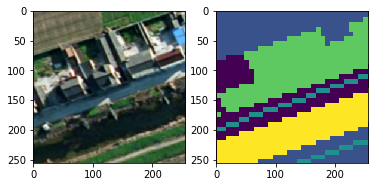

In [21]:
for i,m in data_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy()+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

In [22]:
data_train = data_train.repeat().shuffle(24000).batch(BATCH_SIZE)
data_val = data_val.batch(BATCH_SIZE)

In [23]:
data_train

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

In [24]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def Segnet(nClasses=5, input_height=256, input_width=256):
    inputs = Input(shape=(input_height, input_width, 3))
    #Encoder
    # 256x256
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1=Dropout(0.5)(pool1)
    # 112x112
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2=Dropout(0.5)(pool2)
    # 56x56
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3=Dropout(0.5)(pool3)
    # 28x28
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4=Dropout(0.5)(pool4)
    # 14x14

    # decode
    up7 = UpSampling2D(size=(2, 2))(pool4)
    #up7 = concatenate([up7, conv4], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    #up8 = concatenate([up8, conv3], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.5)(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    #up9 = concatenate([up9, conv2], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.5)(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    #up10 = concatenate([up10, conv1], axis=-1)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    outputHeight = Model(inputs, conv10).output_shape[1]
    outputWidth = Model(inputs, conv10).output_shape[2]
    conv11 = Conv2D(nClasses, (1, 1), padding='same')(conv10)
    conv11 = Activation('softmax')(conv11)

    model = Model(inputs, conv11)
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight
	
    return model

In [25]:
model=Segnet()

In [26]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0   

In [27]:
# 编译模型
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"]
             )

In [28]:
# 导入保存的模型，第二次运行才可以进行的操作
# 给出模型保存的路径以及文件名
model_name = 'Segnet'
#checkpoint_save_path = "./checkpoint/{0}-mineral-type{1}.ckpt".format(model_name,len(dirList)) 
checkpoint_save_path = "./model/{0}.ckpt".format(model_name) 
print('模型保存路径：',checkpoint_save_path)

# 读取模型
if os.path.exists(checkpoint_save_path + '.index'):        # 通过索引表判断保存文件是否存在
    print('-------------load the model-----------------')  # 是，则打印"导入模型"
    model.load_weights(checkpoint_save_path)               # 导入模型

模型保存路径： ./model/Segnet.ckpt
-------------load the model-----------------


In [29]:
# 保存模型，第一次运行执行这一步操作
model_save_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,  # 模型保存路径
                                                          monitor='acc',           # 监视值为 accuracy
                                                         save_weights_only=True,         # 只保留模型参数
                                                         save_best_only=True)            # 只保留最优结果

In [30]:
# 评价指标不在提升时，减少学习率. 当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=5, verbose=1, mode='auto')

In [31]:
# 当监测值不再改善时，该回调函数将中止训练
earlyStopping_callback = keras.callbacks.EarlyStopping(
    # This callback will monitor the loss of the model
    monitor='loss',
    # Training will be interrupted when the accuracy
    # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
    patience=20,
    restore_best_weights = True  )# 是否从具有监测数量的最佳值的时期恢复模型权重。 如果为 False，则使用在训练的最后一步获得的模型权重。

In [33]:
# 训练
history = model.fit_generator(data_train,
                    epochs=106,
                    verbose=1,
                    steps_per_epoch=step_per_epoch,
                    validation_steps=val_step,
                    validation_data=data_val,
                    shuffle=True,
                    callbacks=[model_save_callback, reduce_lr, earlyStopping_callback]
                   )

Epoch 1/106
750/750 [==============================] - 631s 841ms/step - loss: 0.2795 - acc: 0.8865 - val_loss: 0.2817 - val_acc: 0.8864 - lr: 0.0010
Epoch 2/106
750/750 [==============================] - 476s 635ms/step - loss: 0.2762 - acc: 0.8879 - val_loss: 0.2810 - val_acc: 0.8867 - lr: 0.0010
Epoch 3/106
750/750 [==============================] - 596s 795ms/step - loss: 0.2764 - acc: 0.8877 - val_loss: 0.2938 - val_acc: 0.8814 - lr: 0.0010
Epoch 4/106
750/750 [==============================] - 623s 831ms/step - loss: 0.2758 - acc: 0.8882 - val_loss: 0.2861 - val_acc: 0.8846 - lr: 0.0010
Epoch 5/106
750/750 [==============================] - 622s 830ms/step - loss: 0.2788 - acc: 0.8869 - val_loss: 0.2992 - val_acc: 0.8803 - lr: 0.0010
Epoch 6/106
750/750 [==============================] - 570s 760ms/step - loss: 0.2757 - acc: 0.8881 - val_loss: 0.2795 - val_acc: 0.8871 - lr: 0.0010
Epoch 7/106
750/750 [==============================] - 631s 841ms/step - loss: 0.2745 - acc: 0.8886 

Epoch 96/106
750/750 [==============================] - 637s 849ms/step - loss: 0.2480 - acc: 0.8987 - val_loss: 0.2612 - val_acc: 0.8948 - lr: 1.0000e-14
Epoch 97/106
750/750 [==============================] - ETA: 0s - loss: 0.2488 - acc: 0.8984
Epoch 00097: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
750/750 [==============================] - 621s 828ms/step - loss: 0.2488 - acc: 0.8984 - val_loss: 0.2607 - val_acc: 0.8949 - lr: 1.0000e-14


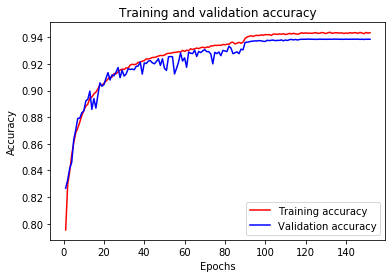

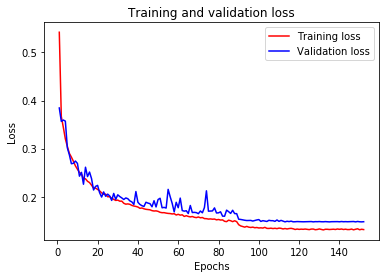

In [66]:
#  保存并绘制loss,acc
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Segnetacc_%s.png", dpi = 1200)
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Segnetloss_%s.png", dpi = 1200)
plt.show()

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
# 保存训练的日志文件
pd.DataFrame(history.history).to_csv('training_log.csv', index=False)

In [29]:
images_test=glob.glob('./dataset/split_train/test/images/*.png')
labels_test=glob.glob('./dataset/split_train/test/labels/*.png')

In [30]:
index = np.random.permutation(len(images_test))
images_test = np.array(images_test)[index] # 对训练集图片进行乱序
labels_test = np.array(labels_test)[index]

In [31]:
images_test[:5]

array(['./dataset/split_train/test/images\\3935.png',
       './dataset/split_train/test/images\\25066.png',
       './dataset/split_train/test/images\\6359.png',
       './dataset/split_train/test/images\\28558.png',
       './dataset/split_train/test/images\\21621.png'], dtype='<U43')

In [32]:
labels_test[:5]

array(['./dataset/split_train/test/labels\\3935.png',
       './dataset/split_train/test/labels\\25066.png',
       './dataset/split_train/test/labels\\6359.png',
       './dataset/split_train/test/labels\\28558.png',
       './dataset/split_train/test/labels\\21621.png'], dtype='<U43')

In [33]:
# 创建数据集
dataset1 = tf.data.Dataset.from_tensor_slices((images_test,labels_test))

In [34]:
dataset1 = dataset1.map(load_image,num_parallel_calls=auto)
dataset1 = dataset1.batch(BATCH_SIZE)

In [36]:
preds=model.evaluate(dataset1)#SegNet

94/94 [==============================] - 11s 116ms/step - loss: 0.2532 - acc: 0.8986


In [35]:
import seaborn as sn
import pandas as pd
def fast_hist(a, b, n):
    #k为掩膜（去除了255这些点（即标签图中的白色的轮廓），其中的a>=0是为了防止bincount()函数出错）
    k = (a >= 0) & (a < n) 
    #bincount()函数用于统计数组内每个非负整数的个数
    #详见https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n) #核心代码

In [36]:
c=pd.DataFrame({'0':[0,0,0,0,0],'1':[0,0,0,0,0],'2':[0,0,0,0,0],'3':[0,0,0,0,0],'4':[0,0,0,0,0]},index=[0,1,2,3,4])
for image, mask in dataset1.take(94): # 从test数据取出一个batch
    pred_mask = model.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    print(pred_mask.shape)
    print(mask.shape)
    mask=np.array(mask).reshape(-1)
    pred_mask=np.array(pred_mask).reshape(-1)
    print(pred_mask.shape)
    print(mask.shape)
    a=fast_hist(mask,pred_mask,5)
    df_cm = pd.DataFrame(a)
    c=pd.concat([c,df_cm])
    print(c)

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
     0    1    2    3    4         0         1         2         3        4
0  0.0  0.0  0.0  0.0  0.0       NaN       NaN       NaN       NaN      NaN
1  0.0  0.0  0.0  0.0  0.0       NaN       NaN       NaN       NaN      NaN
2  0.0  0.0  0.0  0.0  0.0       NaN       NaN       NaN       NaN      NaN
3  0.0  0.0  0.0  0.0  0.0       NaN       NaN       NaN       NaN      NaN
4  0.0  0.0  0.0  0.0  0.0       NaN       NaN       NaN       NaN      NaN
0  NaN  NaN  NaN  NaN  NaN  472470.0    9691.0    8471.0   46367.0   1764.0
1  NaN  NaN  NaN  NaN  NaN   36459.0  881844.0     766.0    3509.0   1824.0
2  NaN  NaN  NaN  NaN  NaN   12380.0    4584.0  102576.0     315.0     29.0
3  NaN  NaN  NaN  NaN  NaN   50364.0    5057.0     311.0  393899.0      0.0
4  NaN  NaN  NaN  NaN  NaN     628.0    3895.0       0.0     115.0  59834.0
(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1         2         3       

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1         2         3        4    0    1    2    3    4
0       NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
0  472470.0    9691.0    8471.0   46367.0   1764.0  NaN  NaN  NaN  NaN  NaN
1   36459.0  881844.0     766.0    3509.0   1824.0  NaN  NaN  NaN  NaN  NaN
2   12380.0    4584.0  102576.0     315.0     29.0  NaN  NaN  NaN  NaN  NaN
3   50364.0    5057.0     311.0  393899.0      0.0  NaN  NaN  NaN  NaN  NaN
4     628.0    3895.0       0.0     115.0  59834.0  NaN  NaN  NaN  NaN  NaN
0  497768.0   40487.0   10529.0   30189.0   1149.0  NaN  NaN  NaN  NaN  NaN
1    8326.0  783010.0    1501.

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1         2         3         4    0    1    2    3    4
0       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0  472470.0    9691.0    8471.0   46367.0    1764.0  NaN  NaN  NaN  NaN  NaN
1   36459.0  881844.0     766.0    3509.0    1824.0  NaN  NaN  NaN  NaN  NaN
2   12380.0    4584.0  102576.0     315.0      29.0  NaN  NaN  NaN  NaN  NaN
3   50364.0    5057.0     311.0  393899.0       0.0  NaN  NaN  NaN  NaN  NaN
4     628.0    3895.0       0.0     115.0   59834.0  NaN  NaN  NaN  NaN  NaN
0  497768.0   40487.0   10529.0   30189.0    1149.0  NaN  NaN  NaN  NaN  NaN
1    8326.0  78301

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1         2         3         4    0    1    2    3    4
0       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0  472470.0    9691.0    8471.0   46367.0    1764.0  NaN  NaN  NaN  NaN  NaN
1   36459.0  881844.0     766.0    3509.0    1824.0  NaN  NaN  NaN  NaN  NaN
2   12380.0    4584.0  102576.0     315.0      29.0  NaN  NaN  NaN  NaN  NaN
3   50364.0    5057.0     311.0  393899.0       0.0  NaN  NaN  NaN  NaN  NaN
4     628.0    3895.0       0.0     115.0   59834.0  NaN  NaN  NaN  NaN  NaN
0  497768.0   40487.0   10529.0   30189.0    1149.0  NaN  NaN  NaN  NaN  NaN
1    8326.0  78301

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3         4    0    1    2    3    4
0        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...       ...  ...  ...  ...  ...  ...
0   569177.0   36885.0   15566.0   38241.0     384.0  NaN  NaN  NaN  NaN  NaN
1     9693.0  626831.0    1640.0    6434.0    3701.0  NaN  NaN  NaN  NaN  NaN
2    20846.0     464.0  113982.0    1559.0       0.0  NaN  NaN  NaN  NaN  NaN
3    62166.0   13373.0     886.0  372335.0       0.0  NaN  NaN  NaN  NaN  NaN
4     3505.0    7727.0       0.0     903.0  190854.0  NaN  NaN  NaN  NaN  NaN

[85 r

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3        4    0    1    2    3    4
0        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...      ...  ...  ...  ...  ...  ...
0   602188.0   19229.0   13507.0   49842.0    781.0  NaN  NaN  NaN  NaN  NaN
1     2954.0  493037.0    2446.0   11336.0   2042.0  NaN  NaN  NaN  NaN  NaN
2    19565.0    1496.0  128888.0    1133.0      0.0  NaN  NaN  NaN  NaN  NaN
3    43262.0   58786.0    2401.0  610678.0    731.0  NaN  NaN  NaN  NaN  NaN
4      543.0    5272.0       0.0     494.0  26541.0  NaN  NaN  NaN  NaN  NaN

[130 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3         4    0    1    2    3    4
0        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...       ...  ...  ...  ...  ...  ...
0   571226.0   18514.0   16038.0   51708.0     637.0  NaN  NaN  NaN  NaN  NaN
1    19321.0  715306.0    1612.0    4432.0    4214.0  NaN  NaN  NaN  NaN  NaN
2    11778.0    2371.0  150054.0     866.0       0.0  NaN  NaN  NaN  NaN  NaN
3    60991.0    9563.0     766.0  340046.0       6.0  NaN  NaN  NaN  NaN  NaN
4      343.0    4929.0       0.0      20.0  112411.0  NaN  NaN  NaN  NaN  NaN

[175 

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   565394.0    8217.0  10877.0   70525.0    2973.0  NaN  NaN  NaN  NaN  NaN
1    11672.0  497551.0   1643.0    4449.0    1854.0  NaN  NaN  NaN  NaN  NaN
2    24434.0    1764.0  70786.0     215.0       0.0  NaN  NaN  NaN  NaN  NaN
3    70982.0    6519.0    365.0  479999.0       0.0  NaN  NaN  NaN  NaN  NaN
4     4886.0   24308.0     50.0     102.0  237587.0  NaN  NaN  NaN  NaN  NaN

[220 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   633626.0   32760.0  20305.0   52812.0    3927.0  NaN  NaN  NaN  NaN  NaN
1    16842.0  772743.0   2713.0    7672.0    1383.0  NaN  NaN  NaN  NaN  NaN
2    18239.0    3785.0  63941.0    1108.0     256.0  NaN  NaN  NaN  NaN  NaN
3    41298.0    7016.0    372.0  272003.0       3.0  NaN  NaN  NaN  NaN  NaN
4     2109.0    7704.0    145.0     155.0  134235.0  NaN  NaN  NaN  NaN  NaN

[265 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3         4    0    1    2    3    4
0        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...       ...  ...  ...  ...  ...  ...
0   611612.0   26583.0   11624.0   67578.0    2436.0  NaN  NaN  NaN  NaN  NaN
1     2272.0  405086.0    1859.0    2377.0    1560.0  NaN  NaN  NaN  NaN  NaN
2    14572.0    3090.0  136286.0       4.0       0.0  NaN  NaN  NaN  NaN  NaN
3    99094.0   11631.0     540.0  557506.0     394.0  NaN  NaN  NaN  NaN  NaN
4      264.0    5944.0       0.0       0.0  134840.0  NaN  NaN  NaN  NaN  NaN

[310 

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   732075.0   31711.0  12529.0   65868.0    2890.0  NaN  NaN  NaN  NaN  NaN
1    12631.0  375533.0    725.0    4468.0    2493.0  NaN  NaN  NaN  NaN  NaN
2    30099.0    2184.0  74583.0      30.0      16.0  NaN  NaN  NaN  NaN  NaN
3    64167.0   12397.0    872.0  547456.0     741.0  NaN  NaN  NaN  NaN  NaN
4     2540.0   10910.0     43.0     772.0  109419.0  NaN  NaN  NaN  NaN  NaN

[355 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   729124.0   10484.0   8910.0   66737.0    1520.0  NaN  NaN  NaN  NaN  NaN
1    10475.0  404618.0   1341.0    2882.0    2223.0  NaN  NaN  NaN  NaN  NaN
2    11023.0     786.0  78680.0     173.0       0.0  NaN  NaN  NaN  NaN  NaN
3    79963.0    8088.0    764.0  460501.0       0.0  NaN  NaN  NaN  NaN  NaN
4      534.0    5280.0      0.0       0.0  213046.0  NaN  NaN  NaN  NaN  NaN

[400 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3        4    0    1    2    3    4
0        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...      ...  ...  ...  ...  ...  ...
0   481918.0   21830.0   10139.0   51790.0   4182.0  NaN  NaN  NaN  NaN  NaN
1     9079.0  728582.0    2134.0    3902.0   2130.0  NaN  NaN  NaN  NaN  NaN
2    16316.0    5452.0  122626.0    1263.0      0.0  NaN  NaN  NaN  NaN  NaN
3    61410.0   15023.0    2133.0  467491.0      0.0  NaN  NaN  NaN  NaN  NaN
4      579.0    6815.0       0.0       0.0  82358.0  NaN  NaN  NaN  NaN  NaN

[445 rows x 10 co

In [37]:
c.groupby(c.index).sum().reset_index()

,index,0,1,2,3,4,0,1,2,3,4
0,0,51553592.0,1906968.0,1179625.0,4661060.0,212724.0,0.0,0.0,0.0,0.0,0.0
1,1,1110605.0,61594263.0,159794.0,507762.0,313593.0,0.0,0.0,0.0,0.0,0.0
2,2,1843178.0,280335.0,10382901.0,100940.0,3386.0,0.0,0.0,0.0,0.0,0.0
3,3,5367768.0,1135450.0,109495.0,40798507.0,28637.0,0.0,0.0,0.0,0.0,0.0
4,4,203731.0,778929.0,3168.0,27953.0,12343636.0,0.0,0.0,0.0,0.0,0.0
